Импорт необходимых библиотек

In [1]:
import pickle
import os

from PIL import Image
import math
import torchvision
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from livelossplot import PlotLossesKeras

Напищем функции для скачивания датасетов

In [6]:
def open_f(filename, back=1):
    filepath = os.path.join('../' * back, 'data', filename)
    with open(filepath, 'rb') as f:
        return pickle.load(f)

labels = open_f('meta', 2)
data_all = open_f('data_train', 2)
data_test = open_f('data_test', 2)

Определим трейновые картинки и ответы в переменные

перемешаем их

In [8]:
shuffle = np.random.permutation(data_all['images'].shape[0])
train_images_full, train_labels_full = data_all['images'][shuffle], data_all['labels'][shuffle].ravel()

Разобьем датасет на трейновый и валидационный

In [9]:
val_size = 0.05

train_ds_x, val_ds_x, train_ds_y, val_ds_y = train_test_split(train_images_full, train_labels_full, test_size=val_size)

Класс DataSequence

In [10]:
class DataSequence(tf.keras.utils.Sequence):
    def __init__(self, x_set, y_set, transform=None, batch_size=512):
        shuffle = np.random.permutation(y_set.shape[0])
        self.x = x_set[shuffle]
        self.y = y_set[shuffle]
        self.transform = transform
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(self.y.shape[0] / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        shuffle = np.random.permutation(batch_x.shape[0])
        batch_x, batch_y = batch_x[shuffle], batch_y[shuffle]
        if self.transform:
            return (
                np.array([np.asarray(self.transform(Image.fromarray(np.uint8(x)))) / 255. for x in batch_x]),
                batch_y
            )
        return batch_x / 255, batch_y

для примера создадим объекта нового класса и визуализируем

In [11]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomInvert(1),
    torchvision.transforms.RandomAffine(4),
    # тут рандомная аугментация
])
ds_visuation = DataSequence(train_ds_x, train_ds_y, batch_size=9)
ds_aug_visuation = DataSequence(train_ds_x, train_ds_y, transform, batch_size=9)

нарисуем несколько изображений без аугментации с использованием нашего класса

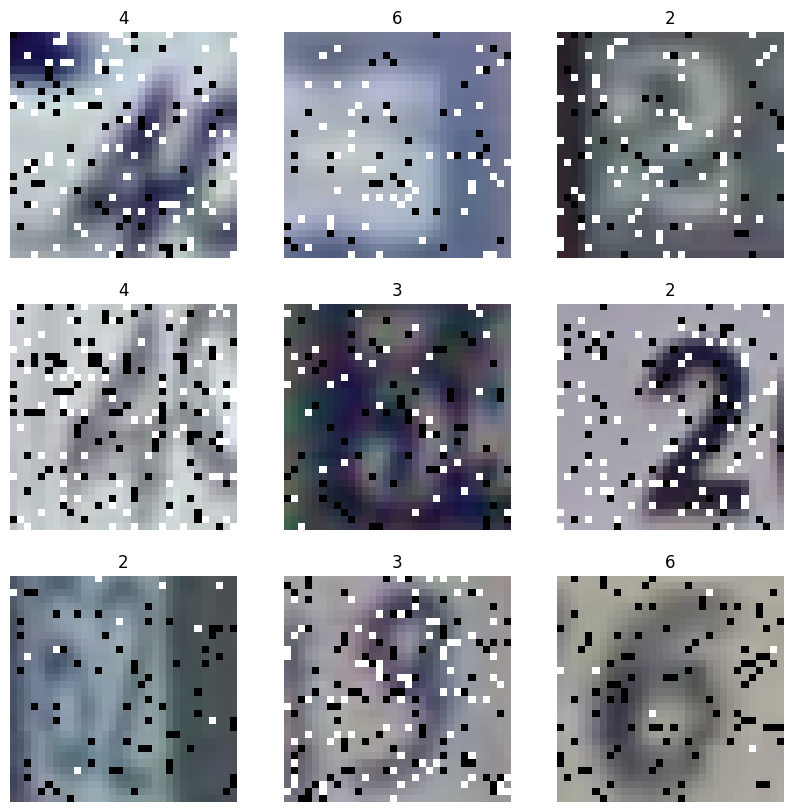

In [12]:
plt.figure(figsize=(10, 10))
images, labels = ds_visuation[0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')

нарисуем несколько изображений с аугментацией с использованием нашего класса

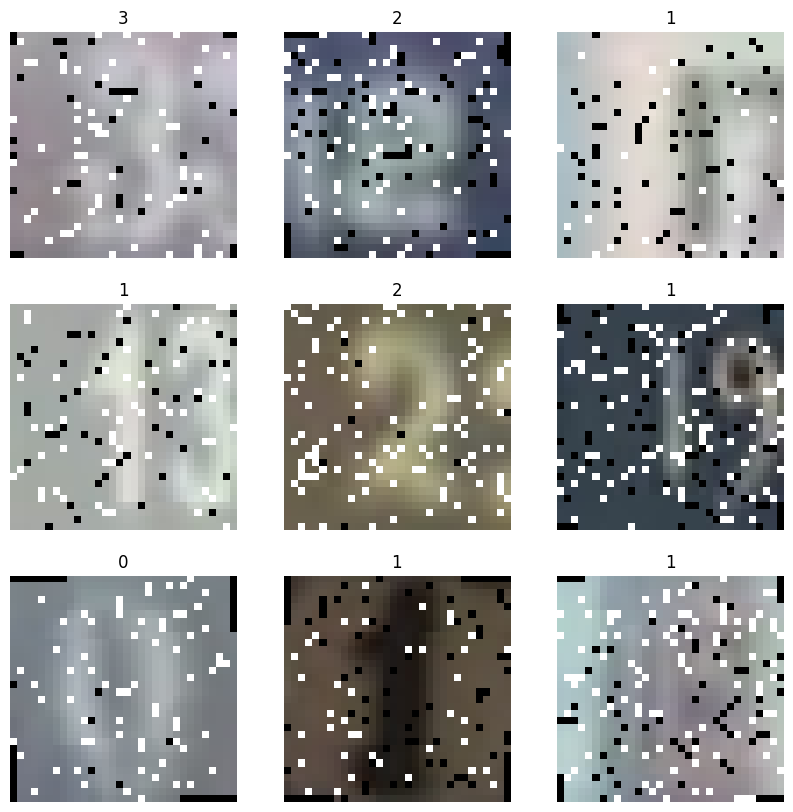

In [13]:
plt.figure(figsize=(10, 10))
images, labels = ds_aug_visuation[0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')

### Проверим работу на модели


создаем трейновый датасет с аугментацией

In [14]:
batch_size = 256
aug_train_ds = DataSequence(train_ds_x, train_ds_y, transform, batch_size=batch_size)

формируем валидационный датасет

In [15]:
val_ds = tf.data.Dataset.from_tensor_slices((val_ds_x, val_ds_y))
val_ds = val_ds.batch(batch_size)

Напишем модель для проверки работы класса

In [16]:
model = tf.keras.Sequential([
    layers.Input(shape=(32, 32, 3), batch_size=batch_size),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),          
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.05), 
    layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (256, 32, 32, 32)         896       
                                                                 
 max_pooling2d (MaxPooling2D  (256, 16, 16, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (256, 16, 16, 32)        128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (256, 16, 16, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (256, 8, 8, 32)          0         
 2D)                                                             
                                                        

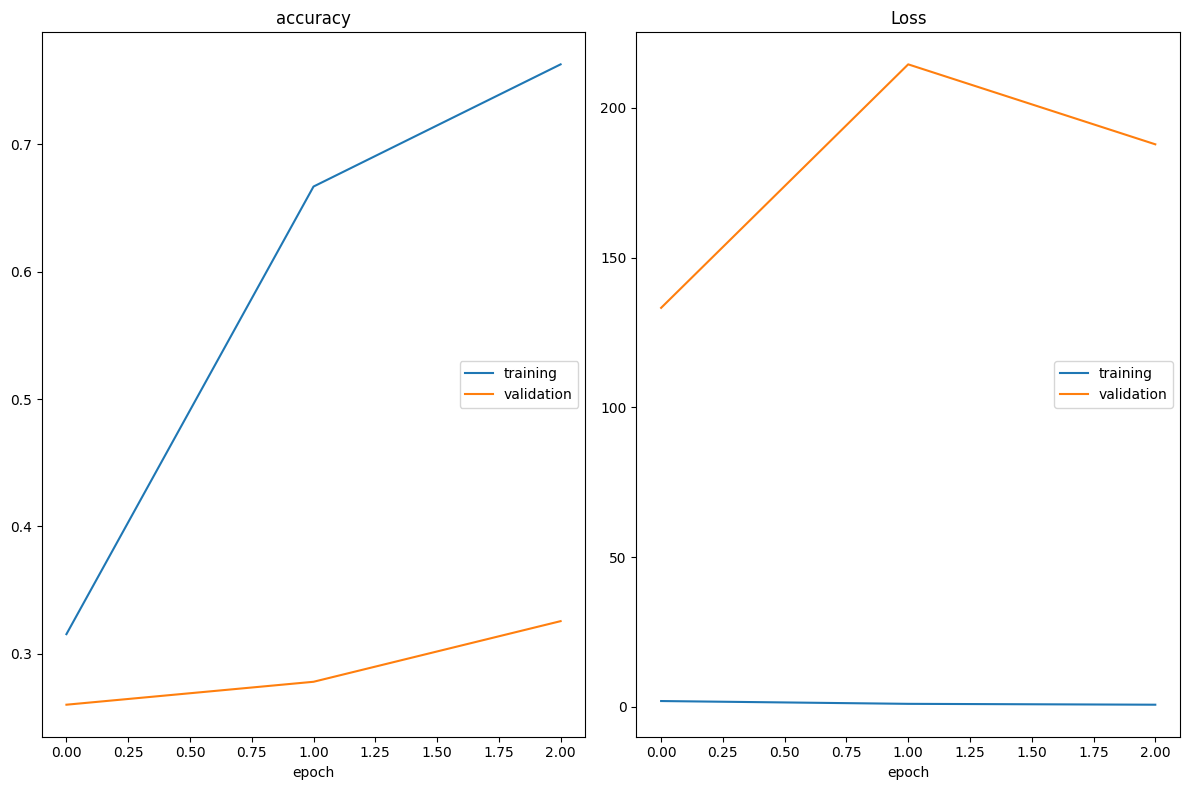

accuracy
	training         	 (min:    0.315, max:    0.763, cur:    0.763)
	validation       	 (min:    0.260, max:    0.326, cur:    0.326)
Loss
	training         	 (min:    0.762, max:    1.985, cur:    0.762)
	validation       	 (min:  133.247, max:  214.536, cur:  187.842)


In [17]:
model.compile(
      optimizer='adam',
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=['accuracy'])

history = model.fit(aug_train_ds, validation_data=val_ds, epochs=3,
              callbacks=[PlotLossesKeras()], verbose=False)

Все работает, перепишем этот код в файл `core/datasets.py`